In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

In [4]:
def generate_grid_dataframe(grid_side_length,):
    """
    Generates a GeoDataFrame based on the grid size of one side.
    
    Parameters:
        grid_side_length (int): The number of squares along one side of the grid.

    Returns:
        GeoDataFrame: A GeoDataFrame containing square geometries and negatively correlated values.
    """
    num_squares = grid_side_length ** 2

    # Create DataFrame
    df = pd.DataFrame({'Index': np.arange(num_squares)})

    # Generate positively correlated normal values
    grid_size = (grid_side_length, grid_side_length)
    mean, std_dev = 0.5, 0.125
    random_values = np.random.normal(mean, std_dev, grid_size)
    smoothed_values = gaussian_filter(random_values, sigma=1.5)  # Spatial correlation

    # Generate a negatively correlated field by flipping values
    negatively_correlated_values = -1 * smoothed_values + (2 * mean)

    # Assign values to the DataFrame
    df['Value'] = negatively_correlated_values.ravel()

    # Function to calculate square coordinates
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % grid_side_length
        y = value // grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

    # Convert to GeoDataFrame with square geometries
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    return gdf

In [5]:
gdf = generate_grid_dataframe(7)  # Generates a 7x7 grid
print(gdf.head())

   Index     Value                             geometry
0      0  0.465732  POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
1      1  0.453164  POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))
2      2  0.443105  POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
3      3  0.447778  POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))
4      4  0.456674  POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))


<Axes: >

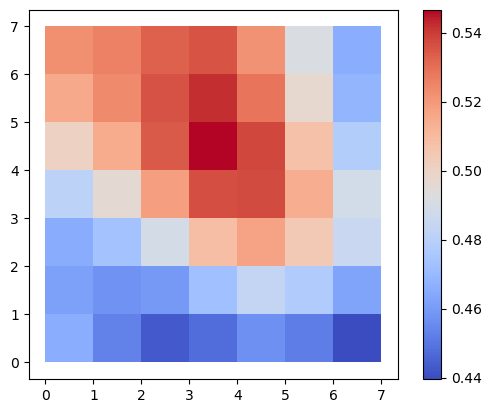

In [6]:
gdf.plot(column='Value', cmap='coolwarm', legend=True)

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

def generate_grid_dataframe(grid_side_length, autocorrelation="positive", random_seed=42):
    """
    Generates a GeoDataFrame based on the grid size of one side with different types of spatial autocorrelation.
    
    Parameters:
        grid_side_length (int): The number of squares along one side of the grid.
        autocorrelation (str): Type of spatial autocorrelation. Options:
                               "none" - No spatial correlation (pure random)
                               "positive" - Spatially smoothed using a Gaussian filter
                               "negative" - Spatially negative correlation (inverted)
        random_seed (int): Random seed for reproducibility.

    Returns:
        GeoDataFrame: A GeoDataFrame containing square geometries and values based on the selected correlation.
    """
    np.random.seed(random_seed)  # Set the random seed for reproducibility

    num_squares = grid_side_length ** 2
    df = pd.DataFrame({'Index': np.arange(num_squares)})

    # Define grid size and statistical parameters
    grid_size = (grid_side_length, grid_side_length)
    mean, std_dev = 0.5, 0.125

    # Generate initial random values
    random_values = np.random.normal(mean, std_dev, grid_size)

    if autocorrelation == "none":
        values = random_values  # No spatial correlation

    elif autocorrelation == "positive":
        values = gaussian_filter(random_values, sigma=1.5)  # Apply Gaussian smoothing for spatial correlation

    elif autocorrelation == "negative":
        smoothed_values = gaussian_filter(random_values, sigma=1.5)
        values = -1 * smoothed_values + (2 * mean)  # Flip values around the mean for negative correlation

    else:
        raise ValueError("Invalid autocorrelation type. Choose from 'none', 'positive', or 'negative'.")

    # Assign values to the DataFrame
    df['Value'] = values.ravel()

    # Function to calculate square coordinates
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % grid_side_length
        y = value // grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

    # Convert to GeoDataFrame with square geometries
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    return gdf


In [16]:
grid_size = 10


In [19]:
gdf_none = generate_grid_dataframe(10, autocorrelation="none", random_seed=42)        # No spatial correlation
gdf_positive = generate_grid_dataframe(10, autocorrelation="positive", random_seed=42)  # Positive spatial correlation
gdf_negative = generate_grid_dataframe(10, autocorrelation="negative", random_seed=42)  # Negative spatial correlation

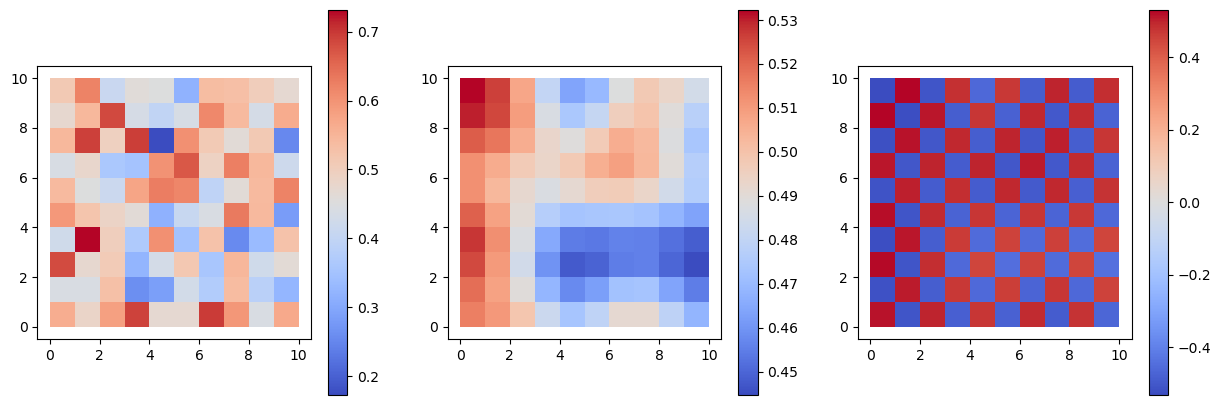

In [20]:
# plot three maps side by side
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

gdf_none.plot(column='Value', cmap='coolwarm', legend=True, ax=axs[0])

gdf_positive.plot(column='Value', cmap='coolwarm', legend=True, ax=axs[1])

gdf_negative.plot(column='Value', cmap='coolwarm', legend=True, ax=axs[2])

plt.show()

In [21]:
import libpysal as ps
from esda.moran import Moran

In [22]:
def calculate_moran_i(gdf, grid_side_length):
    """
    Calculates Moran's I for the given GeoDataFrame.

    Parameters:
        gdf (GeoDataFrame): A spatial dataframe with values and geometry.
        grid_side_length (int): The number of rows/columns in the square grid.

    Returns:
        float: Moran's I value indicating spatial autocorrelation.
    """
    # Create spatial weights matrix (rook contiguity)
    w = ps.weights.lat2W(grid_side_length, grid_side_length)
    w.transform = 'r'  # Row-standardized weights

    # Extract the 'Value' column for Moran's I computation
    values = gdf['Value'].values

    # Compute Moran’s I
    moran = Moran(values, w)

    return moran.I

In [23]:
# Calculate Moran’s I
moran_none = calculate_moran_i(gdf_none, grid_size)
moran_positive = calculate_moran_i(gdf_positive, grid_size)
moran_negative = calculate_moran_i(gdf_negative, grid_size)

# Display Moran's I values
print(f"Moran's I (No Autocorrelation): {moran_none}")
print(f"Moran's I (Positive Autocorrelation): {moran_positive}")
print(f"Moran's I (Negative Autocorrelation): {moran_negative}")

Moran's I (No Autocorrelation): -0.05438727909210017
Moran's I (Positive Autocorrelation): 0.8714759278151759
Moran's I (Negative Autocorrelation): -0.9995556081870076


In [18]:
def generate_grid_dataframe(grid_side_length, autocorrelation="positive", random_seed=42):
    """
    Generates a GeoDataFrame based on the grid size of one side with different types of spatial autocorrelation.
    
    Parameters:
        grid_side_length (int): The number of squares along one side of the grid.
        autocorrelation (str): Type of spatial autocorrelation. Options:
                               "none" - No spatial correlation (pure random)
                               "positive" - Spatially smoothed using a Gaussian filter
                               "negative" - Checkerboard pattern for negative spatial correlation
        random_seed (int): Random seed for reproducibility.

    Returns:
        GeoDataFrame: A GeoDataFrame containing square geometries and values based on the selected correlation.
    """
    np.random.seed(random_seed)  # Set the random seed for reproducibility

    num_squares = grid_side_length ** 2
    df = pd.DataFrame({'Index': np.arange(num_squares)})

    # Define grid size and statistical parameters
    grid_size = (grid_side_length, grid_side_length)
    mean, std_dev = 0.5, 0.125

    # Generate initial random values
    random_values = np.random.normal(mean, std_dev, grid_size)

    if autocorrelation == "none":
        values = random_values  # No spatial correlation

    elif autocorrelation == "positive":
        values = gaussian_filter(random_values, sigma=1.5)  # Apply Gaussian smoothing for spatial correlation

    elif autocorrelation == "negative":
        smoothed_values = gaussian_filter(random_values, sigma=1.5)
        checkerboard = np.indices(grid_size).sum(axis=0) % 2  # Create checkerboard pattern (alternating 0s and 1s)
        values = smoothed_values * (-1) ** checkerboard  # Flip alternating cells

    else:
        raise ValueError("Invalid autocorrelation type. Choose from 'none', 'positive', or 'negative'.")

    # Assign values to the DataFrame
    df['Value'] = values.ravel()

    # Function to calculate square coordinates
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % grid_side_length
        y = value // grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

    # Convert to GeoDataFrame with square geometries
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')

    return gdf

In [24]:
gdf_negative.head()

,Index,Value,geometry
0,0,0.515726,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,1,-0.510445,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
2,2,0.498830,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
3,3,-0.482735,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))"
4,4,0.473196,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))"


<Axes: ylabel='Frequency'>

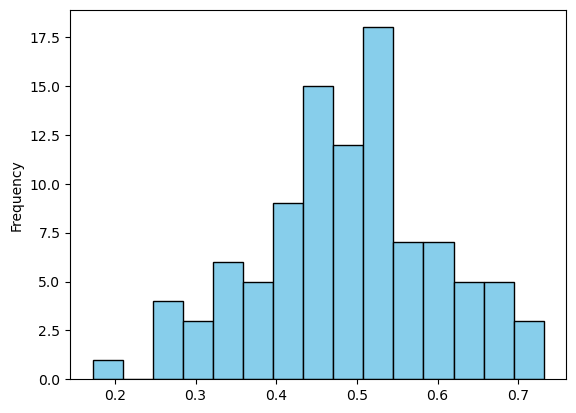

In [27]:
gdf_none['Value'].plot.hist(bins=15, color='skyblue', edgecolor='black')